In [1]:
import pandas as pd

import geopandas as gpd
import folium
from folium import plugins
from folium.features import GeoJsonTooltip

from pycirclize import Circos
from pycirclize.parser import Matrix

In [2]:
import funciones_kwichon as f

# GRÁFICOS DE MIGRACIONES POR PROVINCIA

## Tablas y datos necesarios para la exploración

### Tabla de las migraciones del 2006 al 2021 (excluyendo desde o hacia el extranjero)

In [3]:
solo_migr = pd.read_csv('./csv_files/solo_migr_2006_2021.csv', index_col=0)
solo_migr

SEXO  PROVNAC  EDAD  PROVALTA  MUNIALTA  ANOVAR  PROVBAJA  MUNIBAJA  \
0            1        1     2        48        20    2006         1         0   
1            1        1    53         1         0    2006         1        59   
2            1        1     0        25         0    2006        25       203   
4            1        1    65        28         0    2006        28        79   
5            6        1     3         1         0    2006         1        59   
...        ...      ...   ...       ...       ...     ...       ...       ...   
39922030     1       66    26        50       297    2021        52         1   
39922031     1       66    25        50       297    2021        52         1   
39922032     1       66    45        50       297    2021        52         1   
39922033     1       66    31        51         1    2021        52         1   
39922034     1       66    67        51         1    2021        52         1   

          TAMUALTA  TAMUBAJA  CODMUNIALTA  CODMUNIBAJA  
0                6         1        48020         1000  
1                1         6         1000         1059  
2                1         2        25000        25203  
4                1         6        28000        28079  
5                1         6         1000         1059  
...            ...       ...          ...          ...  
39922030         6         4        50297        52001  
39922031         6         4        50297        52001  
39922032         6         4        50297        52001  
39922033         4         4        51001        52001  
39922034         4         4        51001        52001  

[25844392 rows x 12 columns]

### Tabla con migraciones hacia municipios de menos de 20000 habitantes

Diccionario de los códigos del tamaño de los municipios

In [4]:
cod_tamu = {1: 'Hasta 10.000 habitantes', 
            2: 'Municipio no capital de 10.001 a 20.000',
            3 : 'Municipio no capital de 20.001 a 50.000', 
            4: 'Municipio no capital de 50.001 a 100.000',      
            5: 'Municipio no capital  de más de 100.000',        
            6: 'Municipio capital de provincia'
            
           }

In [5]:
migr_rural = solo_migr[(solo_migr['TAMUALTA'].isin([1,2])) | ((solo_migr['TAMUBAJA'].isin([1,2])))]
migr_rural

SEXO  PROVNAC  EDAD  PROVALTA  MUNIALTA  ANOVAR  PROVBAJA  MUNIBAJA  \
0            1        1     2        48        20    2006         1         0   
1            1        1    53         1         0    2006         1        59   
2            1        1     0        25         0    2006        25       203   
4            1        1    65        28         0    2006        28        79   
5            6        1     3         1         0    2006         1        59   
...        ...      ...   ...       ...       ...     ...       ...       ...   
39922022     1       66    39        50        67    2021        52         1   
39922023     1       66    39        50        67    2021        52         1   
39922024     1       66    38        50        67    2021        52         1   
39922025     6       66    27        50         0    2021        52         1   
39922026     1       66    33        50       251    2021        52         1   

          TAMUALTA  TAMUBAJA  CODMUNIALTA  CODMUNIBAJA  
0                6         1        48020         1000  
1                1         6         1000         1059  
2                1         2        25000        25203  
4                1         6        28000        28079  
5                1         6         1000         1059  
...            ...       ...          ...          ...  
39922022         2         4        50067        52001  
39922023         2         4        50067        52001  
39922024         2         4        50067        52001  
39922025         1         4        50000        52001  
39922026         2         4        50251        52001  

[14559205 rows x 12 columns]

### Tabla de población por provincia y por año

In [6]:
df_pob = pd.read_csv('./datos/poblacion_provincia_sexo.csv', sep=';')
df_pob

Provincias     Sexo  Periodo       Total
0          Total    Total     2021  47.385.107
1          Total    Total     2020  47.450.795
2          Total    Total     2019  47.026.208
3          Total    Total     2018  46.722.980
4          Total    Total     2017  46.572.132
...          ...      ...      ...         ...
4129  52 Melilla  Mujeres     2000      32.287
4130  52 Melilla  Mujeres     1999      27.977
4131  52 Melilla  Mujeres     1998      29.539
4132  52 Melilla  Mujeres     1997         NaN
4133  52 Melilla  Mujeres     1996      29.929

[4134 rows x 4 columns]

In [7]:
# Se prepara el dataframe con la población de cada provincia por año.

# Se eliminan las filas separadas por 'Sexo'
df_pob= df_pob[~((df_pob['Sexo']=='Mujeres')|(df_pob['Sexo']=='Hombres'))]
# Se eliminan las filas donde se indica Total en la columna 'Provincias'
df_pob = df_pob[~(df_pob['Provincias']=='Total')]
# Se elimina la columna Sexo
df_pob.drop(columns='Sexo', inplace=True)
# Se resetea el índice de la tabla
df_pob.reset_index(drop=True, inplace=True)
df_pob

Provincias  Periodo    Total
0     02 Albacete     2021  386.464
1     02 Albacete     2020  388.270
2     02 Albacete     2019  388.167
3     02 Albacete     2018  388.786
4     02 Albacete     2017  390.032
...           ...      ...      ...
1347   52 Melilla     2000   66.263
1348   52 Melilla     1999   56.929
1349   52 Melilla     1998   60.108
1350   52 Melilla     1997      NaN
1351   52 Melilla     1996   59.576

[1352 rows x 3 columns]

In [8]:
# Se crea una columna nueva para separar el código de provincia del nombre de la provincia
df_pob['Cod_prov']= [int(x.split(' ')[0]) for x in df_pob['Provincias']]
df_pob['Provincias'] = df_pob['Provincias'].apply(lambda x: x.split(' ')[1])

In [9]:
df_pob

Provincias  Periodo    Total  Cod_prov
0      Albacete     2021  386.464         2
1      Albacete     2020  388.270         2
2      Albacete     2019  388.167         2
3      Albacete     2018  388.786         2
4      Albacete     2017  390.032         2
...         ...      ...      ...       ...
1347    Melilla     2000   66.263        52
1348    Melilla     1999   56.929        52
1349    Melilla     1998   60.108        52
1350    Melilla     1997      NaN        52
1351    Melilla     1996   59.576        52

[1352 rows x 4 columns]

In [10]:
# Se ordenan las columnas
df_pob = df_pob[['Periodo','Cod_prov', 'Provincias', 'Total']]

In [11]:
# Se filtra por los años del estudio
years = [y for y in range(2006, 2022)]
df_pob = df_pob[df_pob['Periodo'].isin(years)]
df_pob

Periodo  Cod_prov Provincias    Total
0        2021         2   Albacete  386.464
1        2020         2   Albacete  388.270
2        2019         2   Albacete  388.167
3        2018         2   Albacete  388.786
4        2017         2   Albacete  390.032
...       ...       ...        ...      ...
1337     2010        52    Melilla   76.034
1338     2009        52    Melilla   73.460
1339     2008        52    Melilla   71.448
1340     2007        52    Melilla   69.440
1341     2006        52    Melilla   66.871

[832 rows x 4 columns]

In [12]:
# Se ordena por años y código de provincia
df_pob.sort_values(by=['Periodo','Cod_prov'], inplace=True, ignore_index=True)
df_pob

Periodo  Cod_prov        Provincias      Total
0       2006         1       Araba/Álava    301.926
1       2006         2          Albacete    387.658
2       2006         3  Alicante/Alacant  1.783.555
3       2006         4           Almería    635.850
4       2006         5             Ávila    167.818
..       ...       ...               ...        ...
827     2021        48           Bizkaia  1.154.334
828     2021        49            Zamora    168.725
829     2021        50          Zaragoza    967.452
830     2021        51             Ceuta     83.517
831     2021        52           Melilla     86.261

[832 rows x 4 columns]

In [13]:
# Se cambia el nombre de la columna Total por Poblacion
df_pob.columns = ['Periodo', 'Cod_prov', 'Provincias', 'Poblacion']
df_pob

Periodo  Cod_prov        Provincias  Poblacion
0       2006         1       Araba/Álava    301.926
1       2006         2          Albacete    387.658
2       2006         3  Alicante/Alacant  1.783.555
3       2006         4           Almería    635.850
4       2006         5             Ávila    167.818
..       ...       ...               ...        ...
827     2021        48           Bizkaia  1.154.334
828     2021        49            Zamora    168.725
829     2021        50          Zaragoza    967.452
830     2021        51             Ceuta     83.517
831     2021        52           Melilla     86.261

[832 rows x 4 columns]

In [14]:
df_pob.dtypes

Periodo        int64
Cod_prov       int64
Provincias    object
Poblacion     object
dtype: object

In [15]:
# Se cambia a int la columna Poblacion. 
# Antes se ha de eliminar el . de los valores para poder convertirlos en int

In [16]:
df_pob['Poblacion']= df_pob['Poblacion'].apply(lambda x: x.replace('.', ''))

In [17]:
df_pob['Poblacion']= df_pob['Poblacion'].apply(int)

###  Tabla de provincias con datos de geometría (polígonos)

In [18]:
df_prov = gpd.read_file('./geojson_files/provinces.geojson')
df_prov.head()

id    name                                           geometry
0  25  Lleida  MULTIPOLYGON (((0.38507 41.27846, 0.36483 41.3...
1  24    León  POLYGON ((-5.00157 42.28985, -5.03756 42.29792...
2  23    Jaén  POLYGON ((-4.00071 37.40257, -4.01646 37.41711...
3  22  Huesca  POLYGON ((0.33559 41.40771, 0.31535 41.41741, ...
4  21  Huelva  POLYGON ((-6.93132 38.20877, -6.90208 38.20231...

## Periodo de años a visualizar

In [19]:
start_y = 2020   # año inicio
end_y = 2021  # año fin

###  Tabla de saldo y ratio por provincias con datos de geometría (polígonos)

In [20]:
# Se llama a una función que perapra una tabla donde se agrupan los datos por provincias y se muestra el total
# de altas, bajas y el saldo. 
# Se añade también el nombre de la provincia y el polígono para poder mostrar en un mapa 

# Se le pasa por parámetros: la tabla de migraciones,
# los años del periodo a mostrar, la tabla de provincias con datos de geometry y 
# la tabla de población por provincia y año

df_saldo_prov = f.tabla_saldo_prov (solo_migr, start_y, end_y, df_prov, df_pob)

In [21]:
# Se añade una columna con el porcentaje de saldo por población de cada provincia.

df_saldo_prov = df_saldo_prov.assign(RATIO = lambda x: (round(100*x['SALDO'] /x['Poblacion'],2)))
df_saldo_prov

Poblacion  id                    name  \
0      333940   1             Araba/Álava   
1      388270   2                Albacete   
2     1879888   3        Alacant/Alicante   
3      727945   4                 Almería   
4      157664   5                   Ávila   
5      672137   6                 Badajoz   
6     1171543   7           Illes Balears   
7     5743402   8               Barcelona   
8      357650   9                  Burgos   
9      391850  10                 Cáceres   
10    1244049  11                   Cádiz   
11     585590  12      Castelló/Castellón   
12     495045  13             Ciudad Real   
13     781451  14                 Córdoba   
14    1121815  15                A Coruña   
15     196139  16                  Cuenca   
16     781788  17                  Girona   
17     919168  18                 Granada   
18     261995  19             Guadalajara   
19     727121  20                Gipuzkoa   
20     524278  21                  Huelva   
21     222687  22                  Huesca   
22     631381  23                    Jaén   
23     456439  24                    León   
24     438517  25                  Lleida   
25     319914  26                La Rioja   
26     327946  27                    Lugo   
27    6779888  28                  Madrid   
28    1685920  29                  Málaga   
29    1511251  30                  Murcia   
30     661197  31                 Navarra   
31     306650  32                 Ourense   
32    1018784  33                Asturias   
33     160321  34                Palencia   
34    1131065  35              Las Palmas   
35     945408  36              Pontevedra   
36     329245  37               Salamanca   
37    1044887  38  Santa Cruz de Tenerife   
38     582905  39               Cantabria   
39     153478  40                 Segovia   
40    1950219  41                 Sevilla   
41      88884  42                   Soria   
42     816772  43               Tarragona   
43     134176  44                  Teruel   
44     703772  45                  Toledo   
45    2591875  46       València/Valencia   
46     520649  47              Valladolid   
47    1159443  48                 Bizkaia   
48     170588  49                  Zamora   
49     972528  50                Zaragoza   
50      84202  51                   Ceuta   
51      87076  52                 Melilla   

                                             geometry  PROVSALDO   ALTAS  \
0   POLYGON ((-3.03809 42.98133, -3.00435 42.98295...          1   16899   
1   POLYGON ((-2.76145 38.53351, -2.74570 38.54644...          2   17751   
2   MULTIPOLYGON (((-0.76198 37.84687, -0.78672 37...          3  129705   
3   MULTIPOLYGON (((-3.12805 36.75148, -3.13930 36...          4   49926   
4   POLYGON ((-4.57874 40.21700, -4.61697 40.19922...          5   13229   
5   POLYGON ((-6.93132 38.20877, -6.93582 38.22008...          6   27812   
6   MULTIPOLYGON (((1.38818 38.64014, 1.38144 38.6...          7   99130   
7   MULTIPOLYGON (((1.64458 42.11213, 1.68282 42.1...          8  431590   
8   MULTIPOLYGON (((-2.86940 42.74061, -2.85366 42...          9   21642   
9   POLYGON ((-7.23045 39.27832, -7.26644 39.30094...         10   20392   
10  MULTIPOLYGON (((-6.34655 36.79833, -6.35104 36...         11   56552   
11  MULTIPOLYGON (((-0.79796 39.88095, -0.82945 39...         12   42383   
12  MULTIPOLYGON (((-4.94084 39.39464, -4.90711 39...         13   23856   
13  MULTIPOLYGON (((-5.01731 37.59160, -5.03081 37...         14   23209   
14  MULTIPOLYGON (((-9.00951 42.46272, -9.01625 42...         15   71837   
15  POLYGON ((-2.74120 39.31871, -2.77269 39.36879...         16   13986   
16  MULTIPOLYGON (((2.01794 42.10890, 2.00219 42.1...         17   74084   
17  MULTIPOLYGON (((-3.77805 36.73855, -3.78255 36...         18   74783   
18  MULTIPOLYGON (((-1.80557 40.39795, -1.83256 40...         19   33025   
19  MULTIPOLYGON (((-2.54553 43.08797, -2.50505 43...         20   43792   
20  POLYGON ((-6.93132

In [22]:
df_saldo_prov.to_pickle('./kwichon_streamlit/df_saldo_prov.pkl')  # Se guarda la tabla para utilizar con streamlit

## Mapa de saldo de migraciones por provincia

In [23]:
variable = 'SALDO'

In [24]:
# Se llama a una función que devuelve unm mapa coroplético que muestra el saldo de la migración de la población
# por provincias
# Se le pasa por parámetros:
# la tabla de provincias con la geometry, la tabla con los saldos y ratio, los años del periodo a anailzar
# y la variable con los valores a representar, en este caso asignada a 'SALDO'

mapa_saldo = f.plot_map_saldo_prov(df_prov,df_saldo_prov,start_y, end_y,variable)

In [25]:
mapa_saldo

## Mapa por porcentaje de saldo vs población por provincias

In [26]:
variable = 'RATIO'

In [27]:
# Se llama a una función que devuelve unm mapa coroplético que muestra el saldo de la migración de la población
# por provincias
# Se le pasa por parámetros:
# la tabla de provincias con la geometry, la tabla con los saldos y ratio, los años del periodo a anailzar
# y la variable con los valores a representar, en este caso asignada a 'RATIO'

mapa_ratio = f.plot_map_saldo_prov(df_prov,df_saldo_prov,start_y, end_y,variable)

In [28]:
mapa_ratio

## Mapas teniendo en cuenta solo las migraciones desde o hacia municipios de menos de 20.000 habitantes

###  Tabla de saldo y ratio por provincias con datos de geometría (polígonos)

In [29]:
# Se realiza el mismo proceso anterior pero esta vez se utiliza la tabla de migraciones filtrada por destino
# a municipios rurales.

df_saldo_rural = f.tabla_saldo_prov (migr_rural, start_y, end_y, df_prov, df_pob)

In [30]:
# Se añade una columna con el porcentaje de saldo por población de cada provincia.

df_saldo_rural = df_saldo_rural.assign(RATIO = lambda x: (round(100*x['SALDO'] /x['Poblacion'],2)))
df_saldo_rural

Poblacion  id                    name  \
0      333940   1             Araba/Álava   
1      388270   2                Albacete   
2     1879888   3        Alacant/Alicante   
3      727945   4                 Almería   
4      157664   5                   Ávila   
5      672137   6                 Badajoz   
6     1171543   7           Illes Balears   
7     5743402   8               Barcelona   
8      357650   9                  Burgos   
9      391850  10                 Cáceres   
10    1244049  11                   Cádiz   
11     585590  12      Castelló/Castellón   
12     495045  13             Ciudad Real   
13     781451  14                 Córdoba   
14    1121815  15                A Coruña   
15     196139  16                  Cuenca   
16     781788  17                  Girona   
17     919168  18                 Granada   
18     261995  19             Guadalajara   
19     727121  20                Gipuzkoa   
20     524278  21                  Huelva   
21     222687  22                  Huesca   
22     631381  23                    Jaén   
23     456439  24                    León   
24     438517  25                  Lleida   
25     319914  26                La Rioja   
26     327946  27                    Lugo   
27    6779888  28                  Madrid   
28    1685920  29                  Málaga   
29    1511251  30                  Murcia   
30     661197  31                 Navarra   
31     306650  32                 Ourense   
32    1018784  33                Asturias   
33     160321  34                Palencia   
34    1131065  35              Las Palmas   
35     945408  36              Pontevedra   
36     329245  37               Salamanca   
37    1044887  38  Santa Cruz de Tenerife   
38     582905  39               Cantabria   
39     153478  40                 Segovia   
40    1950219  41                 Sevilla   
41      88884  42                   Soria   
42     816772  43               Tarragona   
43     134176  44                  Teruel   
44     703772  45                  Toledo   
45    2591875  46       València/Valencia   
46     520649  47              Valladolid   
47    1159443  48                 Bizkaia   
48     170588  49                  Zamora   
49     972528  50                Zaragoza   
50      84202  51                   Ceuta   
51      87076  52                 Melilla   

                                             geometry  PROVSALDO   ALTAS  \
0   POLYGON ((-3.03809 42.98133, -3.00435 42.98295...          1   12296   
1   POLYGON ((-2.76145 38.53351, -2.74570 38.54644...          2   13016   
2   MULTIPOLYGON (((-0.76198 37.84687, -0.78672 37...          3   58610   
3   MULTIPOLYGON (((-3.12805 36.75148, -3.13930 36...          4   31852   
4   POLYGON ((-4.57874 40.21700, -4.61697 40.19922...          5   11571   
5   POLYGON ((-6.93132 38.20877, -6.93582 38.22008...          6   21503   
6   MULTIPOLYGON (((1.38818 38.64014, 1.38144 38.6...          7   51017   
7   MULTIPOLYGON (((1.64458 42.11213, 1.68282 42.1...          8  193620   
8   MULTIPOLYGON (((-2.86940 42.74061, -2.85366 42...          9   16535   
9   POLYGON ((-7.23045 39.27832, -7.26644 39.30094...         10   17897   
10  MULTIPOLYGON (((-6.34655 36.79833, -6.35104 36...         11   17166   
11  MULTIPOLYGON (((-0.79796 39.88095, -0.82945 39...         12   28164   
12  MULTIPOLYGON (((-4.94084 39.39464, -4.90711 39...         13   18282   
13  MULTIPOLYGON (((-5.01731 37.59160, -5.03081 37...         14   16766   
14  MULTIPOLYGON (((-9.00951 42.46272, -9.01625 42...         15   43023   
15  POLYGON ((-2.74120 39.31871, -2.77269 39.36879...         16   12669   
16  MULTIPOLYGON (((2.01794 42.10890, 2.00219 42.1...         17   58903   
17  MULTIPOLYGON (((-3.77805 36.73855, -3.78255 36...         18   57859   
18  MULTIPOLYGON (((-1.80557 40.39795, -1.83256 40...         19   27642   
19  MULTIPOLYGON (((-2.54553 43.08797, -2.50505 43...         20   32347   
20  POLYGON ((-6.93132

In [31]:
df_saldo_rural.to_pickle('./kwichon_streamlit/df_saldo_rural.pkl')  # Se guarda la tabla para utilizar con streamlit

## Mapa de saldo de migraciones desde o hacia zonas rurales por provincia

In [32]:
variable = 'SALDO'

In [33]:
mapa_saldo_rural = f.plot_map_saldo_prov(df_prov,df_saldo_rural,start_y, end_y,variable)

In [34]:
mapa_saldo_rural

## Mapa por porcentaje de saldo de zonas rurales vs población por provincias

In [35]:
variable = 'RATIO'

In [36]:
mapa_ratio_rural = f.plot_map_saldo_prov(df_prov,df_saldo_rural,start_y, end_y,variable)

In [37]:
mapa_ratio_rural

# Gráfico circular de migraciones

### Preparación de tablas para la visualización

Tabla de códigos de provincias

In [38]:
cod_prov = pd.read_csv('./csv_files/cod_prov.csv', index_col=0)

In [39]:
cod_prov.to_pickle('./kwichon_streamlit/cod_prov.pkl')   # Se guarda la tabla para utilizar con streamlit

Tabla de códigos de las comunidades autónomas

In [40]:
cod_ccaa = pd.read_csv('./datos/MIGRACIONES/cod_ccaa.csv', sep=';')

In [41]:
cod_ccaa.to_pickle('./kwichon_streamlit/cod_ccaa.pkl')   # Se guarda la tabla para utilizar con streamlit

Tabla de migraciones entre provincias

In [42]:
# diccionario de códigos y nombres de provincias
dict_cod_prov = dict(zip(cod_prov['CPRO'], cod_prov['NOMBRE']))

In [43]:
# Tabla filtrada con las columnas de las migraciones y de los nombres de las provincias
df_circ=solo_migr[['PROVALTA','ANOVAR','PROVBAJA']]

In [44]:
df_circ.to_pickle('./kwichon_streamlit/df_circ.pkl')  # Se guarda la tabla para utilizar con streamlit

In [45]:
# Se filtra la tabla con el periodo de años seleccionado

year = [y for y in range(start_y,end_y+1)]
df_circ=df_circ[df_circ['ANOVAR'].isin(year)]
df_circ

PROVALTA  ANOVAR  PROVBAJA
35888342         1    2020         1
35888343         1    2020         1
35888344         1    2020         1
35888345         1    2020         1
35888346         1    2020         1
...            ...     ...       ...
39922030        50    2021        52
39922031        50    2021        52
39922032        50    2021        52
39922033        51    2021        52
39922034        51    2021        52

[3198255 rows x 3 columns]

In [46]:
# Se agrupa por provincias de alta y baja para contar el número de migraciones por cada caso.
df_circ = df_circ.groupby(by=['PROVBAJA','PROVALTA'], as_index=False).count()
df_circ

PROVBAJA  PROVALTA  ANOVAR
0            1         1    6227
1            1         2      24
2            1         3     233
3            1         4      51
4            1         5      13
...        ...       ...     ...
2695        52        47      15
2696        52        48      35
2697        52        49       6
2698        52        50     116
2699        52        51      84

[2700 rows x 3 columns]

In [47]:
# Lista de columnas a reemplazar por los nombres
col_list = ['PROVBAJA', 'PROVALTA']

In [48]:
# Se llama a una fución que reemplaza los códigos de provincia por sus nombres 
df_circ_name = f.replace_col_data(df_circ, col_list, dict_cod_prov)
df_circ_name

PROVBAJA          PROVALTA  ANOVAR
0     Araba/Álava       Araba/Álava    6227
1     Araba/Álava          Albacete      24
2     Araba/Álava  Alicante/Alacant     233
3     Araba/Álava           Almería      51
4     Araba/Álava             Ávila      13
...           ...               ...     ...
2695      Melilla        Valladolid      15
2696      Melilla           Bizkaia      35
2697      Melilla            Zamora       6
2698      Melilla          Zaragoza     116
2699      Melilla             Ceuta      84

[2700 rows x 3 columns]

In [49]:
# Se llama a una función que devuelve una lista donde se ordenan las provincias que aparecen en la tabla
# por comunidades autónomas
# Se le pasa por parámetros la tabla de las migraciones por provincia y la tabla de códigos de CCAA

order = f.order_circle(df_circ_name, cod_ccaa)

## Gráfico del  total de migraciones por provincias

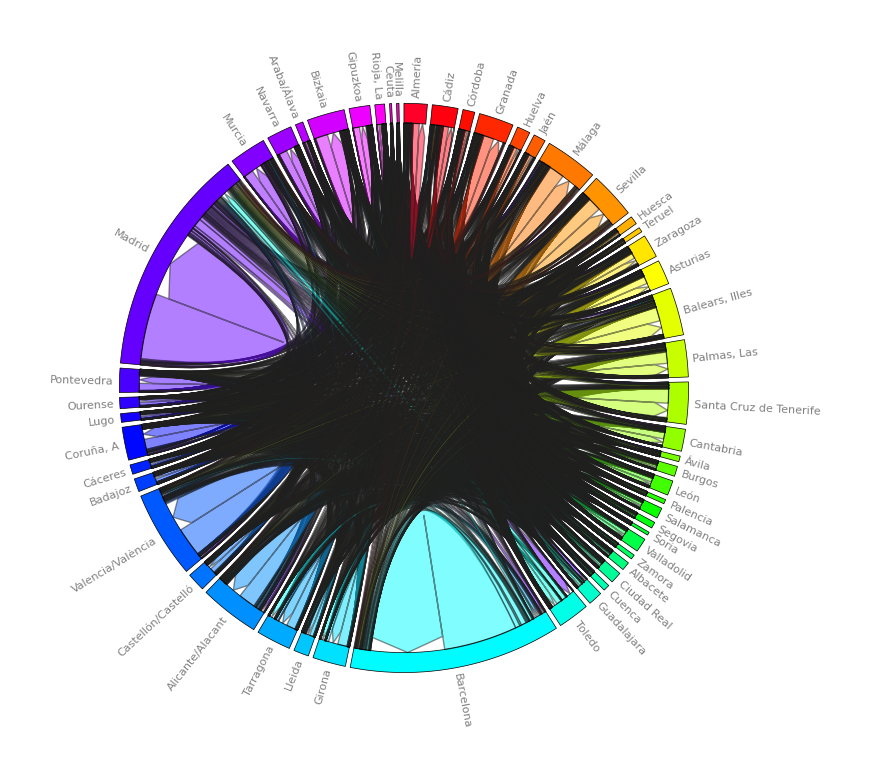

In [50]:
# Se llama a una función para mostrar el gráfico en el orden establecido.
# Se le pasa por parámetros la tabla y la lista con el orden deseado 

f.plot_circle (df_circ_name, order)

Se observa que la mayoría de ellas se quedan en la misma provincia.
Se prepara otro gráfico eliminando estas migraciones dentro de la misma provincia para analizar mejor

## Gráfico de migraciones entre provincias

In [51]:
# Se filtra la tabla eliminando migraciones a la misma provincia y las migraciones menores al 10% del valor máximo
df_circ_reducido = df_circ_name[~(df_circ_name['PROVBAJA']==df_circ_name['PROVALTA'])]

# Se establece el límite de número de migraciones a representar en el mapa
limite_migr = abs(df_circ_reducido['ANOVAR'].max())*10/100
df_circ_reducido = df_circ_reducido[abs(df_circ_reducido['ANOVAR'])>limite_migr]

In [52]:
order_reducido = f.order_circle(df_circ_reducido, cod_ccaa)

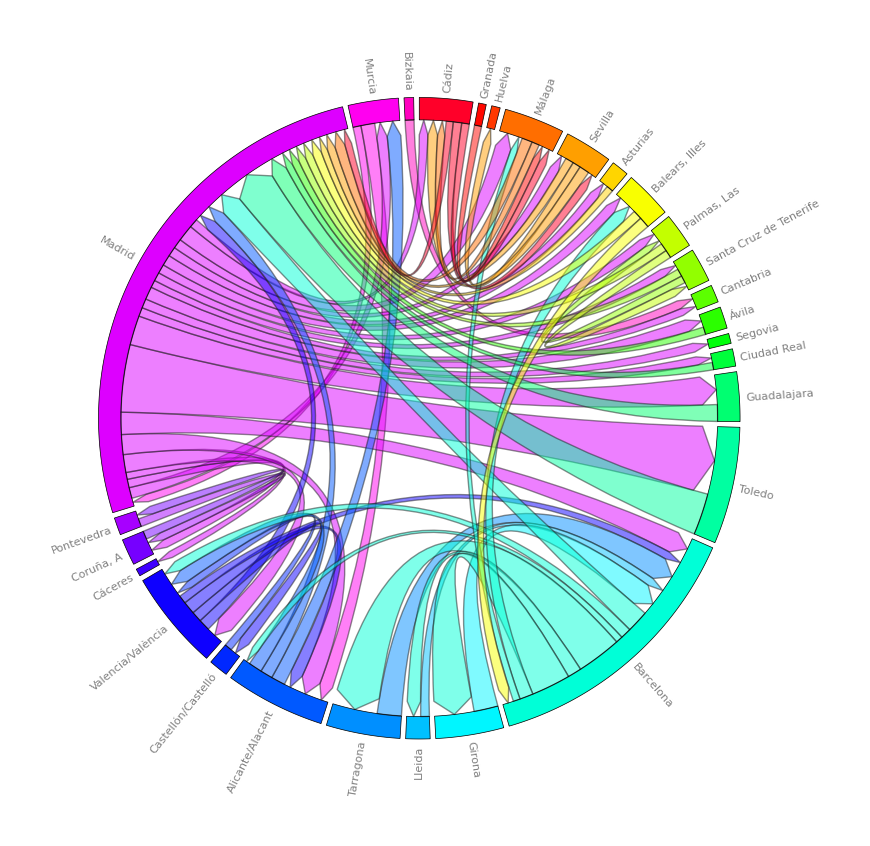

In [53]:
f.plot_circle (df_circ_reducido,order_reducido)

# Solo migraciones desde o hacia zonas rurales

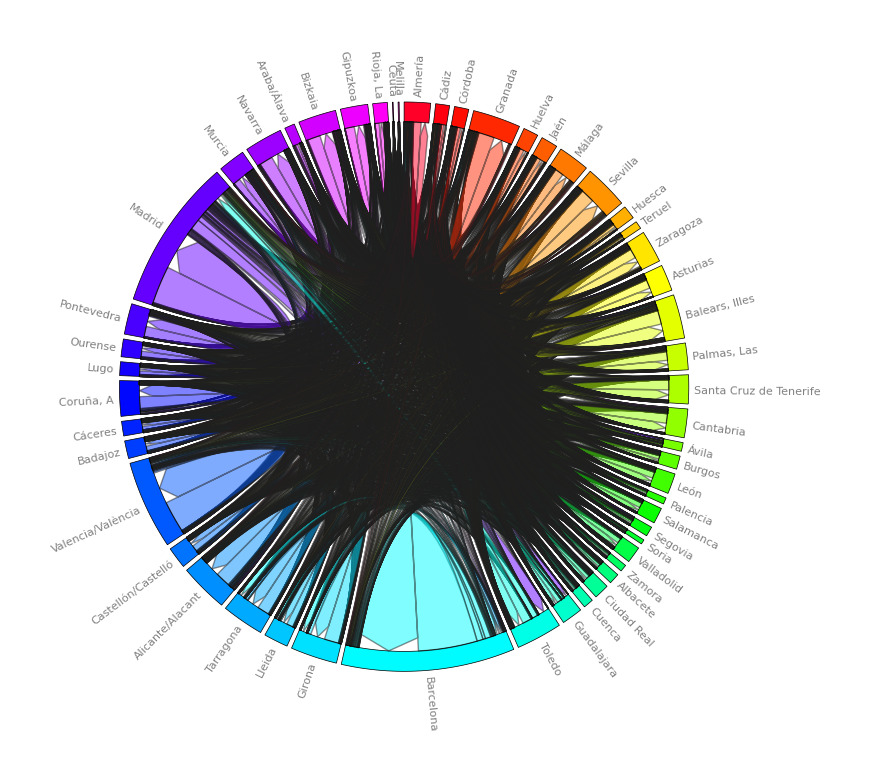

In [54]:
# Se realiza el mismo proceso que antes pero con la tabla de migraciones solo a zonas rurales (tabla migr_rural) 

df_circ_rural=migr_rural[['PROVALTA','ANOVAR','PROVBAJA']]


df_circ_rural.to_pickle('./kwichon_streamlit/df_circ_rural.pkl')  # Se guarda la tabla para utilizar con streamlit

year = [y for y in range(start_y,end_y+1)]
df_circ_rural=df_circ_rural[df_circ_rural['ANOVAR'].isin(year)]
df_circ_rural = df_circ_rural.groupby(by=['PROVBAJA','PROVALTA'], as_index=False).count()

col_list = ['PROVBAJA', 'PROVALTA']

df_circ_rural_name = f.replace_col_data(df_circ_rural, col_list, dict_cod_prov)

order = f.order_circle(df_circ_rural_name, cod_ccaa)

f.plot_circle (df_circ_rural_name, order)

## Gráfico de migraciones desde o hacia zonas rurales entre provincias

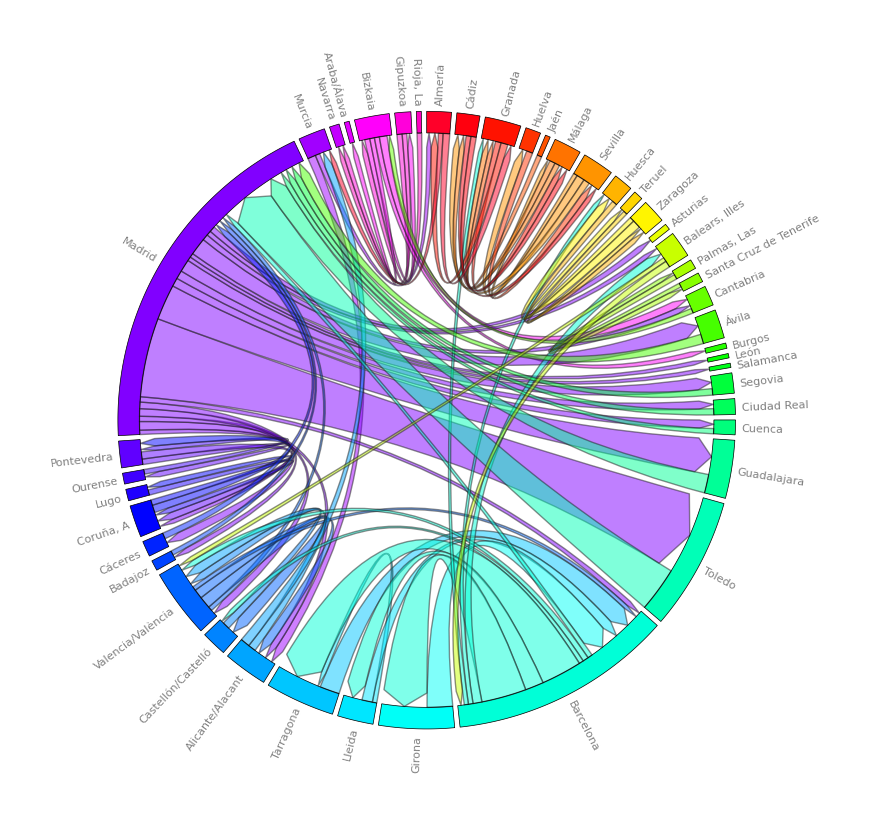

In [55]:
# Se filtra la tabla eliminando migraciones a la misma provincia y las migraciones menores al 5% del valor máximo
df_circ_r_reducido = df_circ_rural_name[~(df_circ_rural_name['PROVBAJA']==df_circ_rural_name['PROVALTA'])]

limite_migr = abs(df_circ_r_reducido['ANOVAR'].max())*5/100
df_circ_r_reducido = df_circ_r_reducido[abs(df_circ_r_reducido['ANOVAR'])>limite_migr]

order_r_reducido = f.order_circle(df_circ_r_reducido, cod_ccaa)

f.plot_circle (df_circ_r_reducido,order_r_reducido)